# Гладких Андрей, группа 9383

# Практическая работа №2:  Практическое применение дискретного преобразования Фурье c использованием библиотек Python для анализа речевых сигналов.

 ### Вариант 2.

In [1]:
import wave
import math
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def getSampleAt(wav, index):
    wav.setpos(index)
    return np.frombuffer(wav.readframes(1), dtype=np.int16)[0]

def writeWav(fileName, params, data):
    wavToWrite = wave.open(str(fileName) + ".wav", "wb")
    wavToWrite.setparams(params)
    wavToWrite.writeframes(np.array(data, dtype="int16").tobytes())
    wavToWrite.close()

wavFile = wave.open("lab2.wav", "rb")

samplesAmount = wavFile.getnframes()
rawWavX = range(samplesAmount)
rawWavY = np.array([getSampleAt(wavFile, i) for i in range(samplesAmount)], dtype=np.float64)

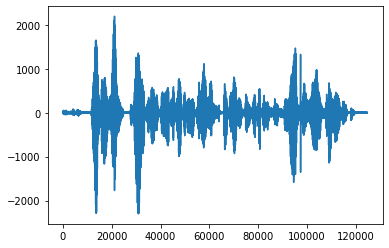

In [3]:
plt.plot(rawWavX, rawWavY)

## 1. Используя ДПФ построить траекторию основного тона (F0) на записи своего голоса

1. Разбиваем сигнал на отрезки длиной $N$ . Рекомендуется работа с перекрытиями: сдвиг для следующего интервала ${0.5N}$, ${0.25N}$.
2. На каждом отрезке сигнал предварительно умножаем на окно, затем вычисляем ДПФ и на его основе амплитудный спектр в интервале ${(0,N/2)}$.
3. Ищем существенное максимальное значение амплитудного спектра на отрезке ${[n_l,n_u]}$ — это будет частота основного тона ${F0}$ (точка амплитудного спектра ${n_0}$). Если такого максимума нет — это интервал паузы или не вокализованного звука. Полагаем ${F0 = 0}$.

In [4]:
framerate = wavFile.getframerate()
N = 512
spectrumResolution = framerate // N
nl = 80 // spectrumResolution
nu = 200 // spectrumResolution

In [5]:
def M(N):
    return np.exp(2 * np.pi * 1j / N)

#Дискретное преобразование Фурье
def DFT(x):
    x = np.array(x, dtype=np.float64)
    N = len(x)
    res = np.zeros(N, dtype=complex)
    for k in range(N):
        for j in range(N):
            res[k] += x[j] * M(N) ** (-k * j)
    return res

In [6]:
%%time
#Строим интервалы
intervals = np.array_split(np.array(rawWavY, dtype=np.float64), len(rawWavY) / N)

#Умножаем на окно Хемминга
intervals = np.array([interval * np.hamming(len(interval)) for interval in intervals], dtype=object)

#Применяем дискретное преобразование Фурье
dftValues = np.array([DFT(interval) for interval in intervals], dtype=object)

Wall time: 5min 46s


In [7]:
#Строим амплитудный спектр
amplitudeSpectrum = np.array([np.absolute(interval[:len(interval)//2]) for interval in dftValues], dtype=object)

In [8]:
#Получаем F0
def getZeroFormant(nl, frame):
    maxIndex = np.argmax(frame)
    maxVal = frame[maxIndex]
    meanVal = np.mean(frame)
    if maxVal > 2 * meanVal:
        return nl + maxIndex
    return 0

formantZero = []
mainFreqIndexArr = []
for interval in amplitudeSpectrum:
    mainFreqIndex = getZeroFormant(nl, interval[nl:nu + 1])
    mainFreqIndexArr.append(mainFreqIndex)
    formantZero += [spectrumResolution * mainFreqIndex for i in range(len(interval))]

Средняя F0: 150.15


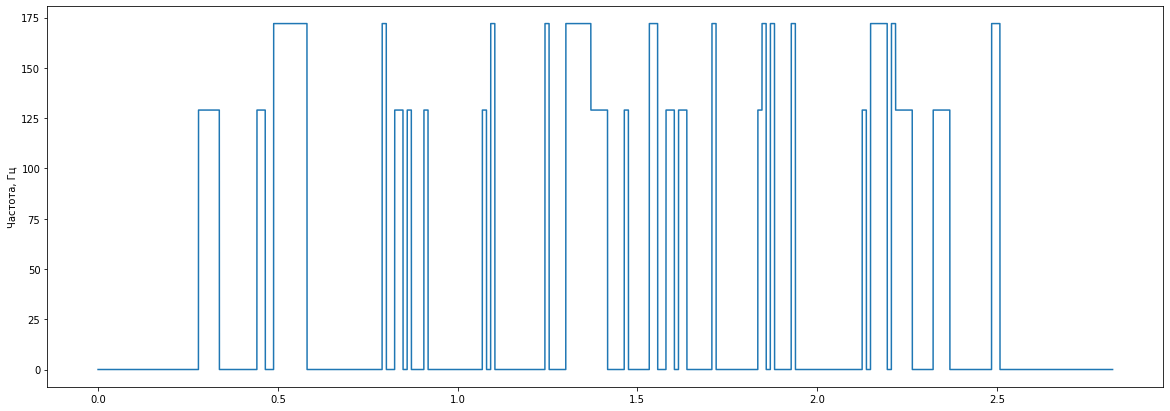

In [9]:
plt.figure(figsize=(20,7))
plt.ylabel("Частота, Гц")
plt.plot(np.arange(len(formantZero))/framerate, formantZero)

meanFreq = np.sum(formantZero) / np.count_nonzero(formantZero)

print("Средняя F0: %.2f"%meanFreq)

## 2. Используя ДПФ построить траектории второй, третьей и четвертой формантных частот на записи своего голоса

4. В окрестности точки ${2n_0}$ ищем максимальное значение амплитудного спектра, которое должно быть существенно меньше значения в точке ${n_0}$. Если это предположение верно, то мы нашли частоту второй форманты ${F1}$. Если нет — второй форманты у сигнала на этом отрезке нет. Полагаем ${F1 = 0}$.
5. Далее проводим поиск для третьей форманты в окрестности точки ${3n_0}$. Повторяем процесс для четвертой форманты в окрестности точки ${4n_0}$.

In [10]:
def getNthFormant(nl, frame, prevMax):
    maxIndex = np.argmax(frame)
    maxVal = frame[maxIndex]
    meanVal = np.mean(frame)
    if maxVal > 2 * meanVal and maxVal < prevMax:
        return nl + maxIndex
    return 0

#Получаем F1, F2, F3 
formants = [[] for i in range(4)]
for r in range(len(amplitudeSpectrum)):
    mainFreq = mainFreqIndexArr[r]
    interval = amplitudeSpectrum[r]
    for i in range(1,4):
        if mainFreq != 0:
            lowerBorder = mainFreq * (i + 1) - (nu - nl) // 2
            upperBorder = lowerBorder + (nu - nl) * 2
            formant = getNthFormant(lowerBorder, interval[lowerBorder:upperBorder], interval[mainFreq])
            formants[i] += [formant * spectrumResolution for j in range(int(len(interval)))]
        else:
            formants[i] += [0 for j in range(int(len(interval)))]

Средняя F1: 318.20


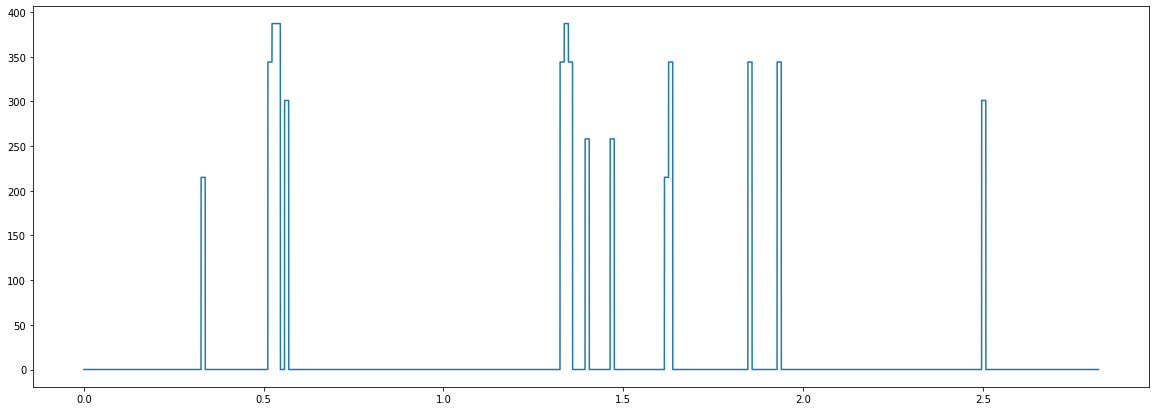

In [11]:
index = 1
plt.figure(figsize=(20,7))
plt.plot(np.arange(len(formants[index]))/framerate, formants[index])

meanFreq = np.sum(formants[index]) / np.count_nonzero(formants[index])

print("Средняя F1: %.2f"%meanFreq)

Средняя F2: 444.33


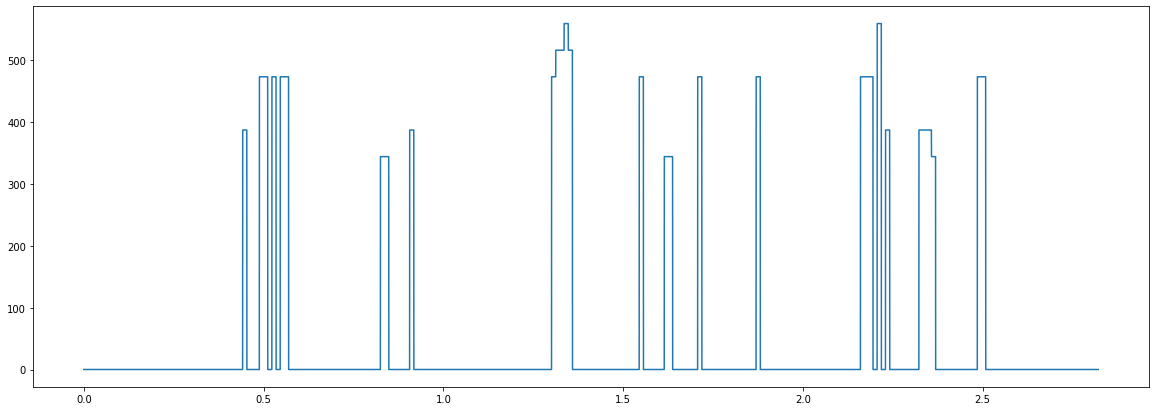

In [12]:
index = 2
plt.figure(figsize=(20,7))
plt.plot(np.arange(len(formants[index]))/framerate, formants[index])

meanFreq = np.sum(formants[index]) / np.count_nonzero(formants[index])

print("Средняя F2: %.2f"%meanFreq)

Средняя F3: 533.92


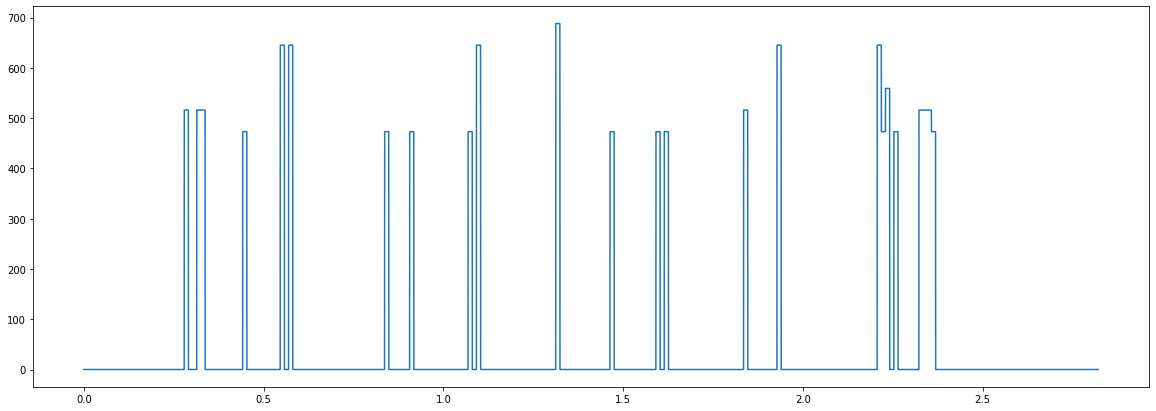

In [13]:
index = 3
plt.figure(figsize=(20,7))
plt.plot(np.arange(len(formants[index]))/framerate, formants[index])

meanFreq = np.sum(formants[index]) / np.count_nonzero(formants[index])

print("Средняя F3: %.2f"%meanFreq)

Заметим, что, как и ожидалось, ${F_1 \approx 2F_0, F_2 \approx 3F_0, F_3 \approx 4F_0}$.

## 3. Построить сонограмму по записи своего голоса.

1. Повторяем первые три шага алгоритма вычисления ${F0}$.
2. Находим максимальное значение амплитудного спектра для ${F0}$ по всему сигналу — ${A_{Max}}$.
3. Интенсивность темного (или цвета) определяем относительно значения ${A_{Max}}$.
4. Интенсивность столбца значений амплитудного спектра выводим в интервале
${50 − 4000 Hz}$.
5. Размерность столбца определяется пользователем.

In [14]:
#Заполняем сонограмму
sonogram = np.zeros((len(amplitudeSpectrum[0]),len(amplitudeSpectrum)))
for i, interval in enumerate(amplitudeSpectrum):
    Amax = np.max(interval)
    sonogramRow = []
    for j in range(len(interval)):
        hz = j * spectrumResolution
        if hz > 50:
            if hz > 4000:
                continue
            sonogram[j][i] = interval[j] / Amax

Сонограмма:


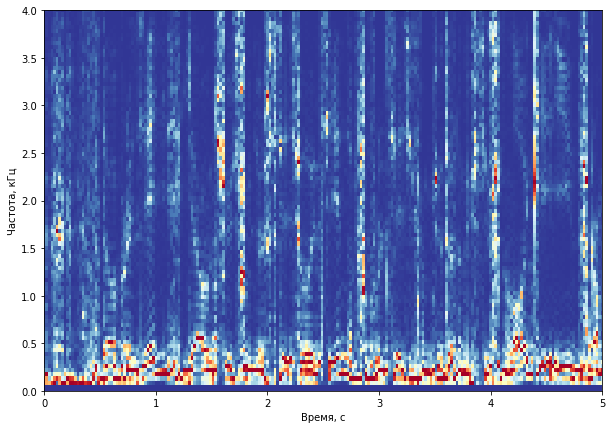

In [15]:
print("Сонограмма:")
plt.figure(figsize=(10,7))
plt.xlabel("Время, с")
plt.ylabel("Частота, кГц")
plt.ylim(top=4)
plt.xlim(right=5)
time = np.arange(len(sonogram[0])) / spectrumResolution
freqs = np.arange(len(sonogram)) * spectrumResolution / 1000

plt.pcolormesh(time, freqs, sonogram, cmap = plt.cm.RdYlBu_r, shading='auto')
plt.show()